alpha-mind的data文件夹提供了对于因子数据进行中性化、标准化和去极值化的函数：
* [neutralize.py](https://github.com/alpha-miner/alpha-mind/blob/master/alphamind/data/neutralize.py)：提供了风险中性化函数*neutralize*
* [standardize.py](https://github.com/alpha-miner/alpha-mind/blob/master/alphamind/data/standardize.py): 提供了标准化函数*standardize*和与sklearn类似的算子*Standardizer*以及*GroupStandardizer*
* [winsorize.py](https://github.com/alpha-miner/alpha-mind/blob/master/alphamind/data/winsorize.py)：提供了去极值化的函数*winsorize_normal*

标准化和去极值化函数的特别之处在于，他们还可以按组别（对应的实际问题，比如按行业）进行数据处理。


### 去极值化处理
#### 全截面处理

alpha-mind提供了*winsorize_normal*这一函数，假设数据服从正太分布，进行去极值化处理。

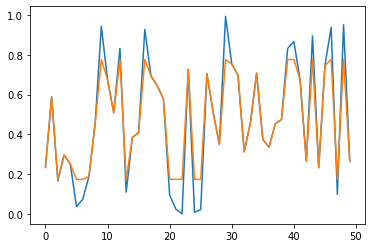

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from alphamind.data.winsorize import winsorize_normal

# 假设有50只股票，每只股票有1个因子，构成一个矩阵
factors = np.random.rand(50, 1)

# 为了展示方便，取一个标准差为上下界
clean_factors = winsorize_normal(factors, num_stds=1)

%matplotlib inline
plt.plot(factors)
plt.plot(clean_factors)


#### 分行业处理
有时候需要进行分组去极值化，如按行业来分组。针对这种情况，只需要多传递一个分组参数给*winsorize_normal*。

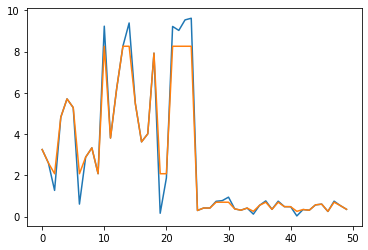

In [3]:
# 假设所有股票可分为2个组别（如行业），前25个和后25个分属不同类别
industry = np.concatenate([np.array([1.0]*25), np.array([2.0]*25)])

# 此时令前25个因子和后25个因子的标准差不一样
factors =  np.concatenate([ 10*np.random.rand(25, 1),  np.random.rand(25, 1)])

# 为了展示方便，取一个标准差为上下界
clean_factors = winsorize_normal(factors, num_stds=1, groups=industry)

%matplotlib inline
plt.plot(factors)
plt.plot(clean_factors)




### 标准化处理
标准化函数的使用与去极值化类似,故不再重复，下文仅展示分组进行标准化处理的例子。

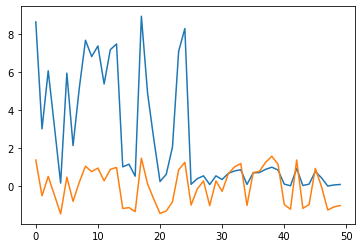

In [4]:
from alphamind.data.standardize import standardize

# 假设所有股票可分为2个组别（如行业），前25个和后25个分属不同类别
industry = np.concatenate([np.array([1.0]*25), np.array([2.0]*25)])

# 此时令前25个因子和后25个因子的标准差不一样
factors =  np.concatenate([ 10*np.random.rand(25, 1),  np.random.rand(25, 1)])

# 为了展示方便，取一个标准差为上下界
clean_factors = standardize(factors, groups=industry)

%matplotlib inline
plt.plot(factors)
plt.plot(clean_factors)


另外还提供了类似sklearn风格的算子*Standardizer*和*GroupedStandardizer*，使用*fit,transform*方法可以得到同样的效果。具体请参见sklearn相关的帮助以及本项目代码。

### 中性化处理
#### 风险（风格）中性化

In [5]:
from alphamind.data.neutralize import neutralize

# 假设有30只股票，每只股票有10个因子，构成一个矩阵
raw_factors = np.random.rand(30, 10)

# 假设每只股票对应有4个风险因子，构成一个矩阵
risk_factors = np.random.rand(30, 4)

# 因子的风险中性化，就是原始因子对风险因子求线性回归后的残差
ret_neutralize_1 = neutralize(risk_factors, raw_factors)


#### 风险以及行业中性化
生成环境中一般还需要进行行业中性化，对于*neutralize*来说只需要增加一个入参，把每只股票对应的行业标签以np数组传递进去。

In [6]:
# 假设所有股票可分为3个组别（如行业）
industry = np.random.randint(3, size=30)

# 对因子进行风险和行业中性化
ret_neutralize_2 = neutralize(risk_factors, raw_factors, industry)

In [7]:
# 如果令所有行业都是一样，那么将得到与 ret_neutralize_1一样的结果
industry = np.random.randint(1, size=30)
ret_neutralize_3 = neutralize(risk_factors, raw_factors, industry)
# print(ret_neutralize_1)

# print(ret_neutralize_3)

#### 仅行业中性
如果只想进行行业中性化处理，那么可以令风险因子（*neutralize*的第一个入参）为全部元素为1的矩阵。下面进行一个简单测试。

In [8]:
# 假设有10只股票，每只股票有1个因子
factor = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0])

# 假设所有股票可分为2个行业，前5和后5 分属于不同行业
industry = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0])

risk_factors = np.ones((10, 1))

ret_neutralize_4 = neutralize(risk_factors, factor, industry)

print(ret_neutralize_4)

[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-2.]
 [-1.]
 [ 0.]
 [ 1.]
 [ 2.]]


行业中性化后的因子为原始因子减去行业内平均值，结果与预期一样。

### 预处理合成函数
alpha-mind 还提供了一个预处理函数*factor_processing*, 集成了以上描述函数的所有功能，可以一步进行因子数据的预处理功能。
- 入参*pre_process*需传递预处理的子函数列表，如去极值化和标准化。如果传递了风险因子的参数，中性化函数会在预处理之后自动触发。
- 入参*post_process*指的是在中性化处理（如果有的话）或*pre_process*完成之后，还需要进行的处理。同样可以将去极值化和标准化函数作为列表传递进去。

In [9]:
from alphamind.data.processing import factor_processing
from alphamind.data.standardize import standardize

# 假设有30只股票，每只股票有10个因子，构成一个矩阵
raw_factors = np.random.rand(30, 10)

# 假设每只股票对应有4个风险因子，构成一个矩阵
risk_factors = np.random.rand(30, 4)

# 假设所有股票可分为3个组别（如行业）
industry = np.random.randint(3, size=30)

ret_preprocess = factor_processing(raw_factors,
                                   pre_process=[winsorize_normal, standardize],
                                   risk_factors=risk_factors,
                                   groups=industry)
